# Starting Kit - Relevance

# Introduction to Challenge
The RelevAI project, which is in the field of Information Retrieval (IR), focuses on academic literature. It is driven by the need to classify the relevance of papers in the scientific literature, a task that grows harder with large text volumes and diverse topics. The project aims to automate the process of assessing document relevance to specific prompts or queries, which has the potential to save users valuable time and effort.

Traditional methods like text matching and keyword search often miss contextual meaning and word relationships, resulting in inaccurate relevance assessments. Therefore, this challenge proposes users to come up with Artificial Intelligence techniques to improve this task, capturing semantic and contextual aspects of the text to better predict its relevance. The successful development of an effective relevance ranking algorithm can have a significant impact on society. It can enhance literature reviews, accelerate scientific research, expedite breakthroughs in diverse fields, facilitate efficient literature searches, simplify information access, and enhance learning and decision-making processes.

# Introduction to Data
This challenge aims to categorize candidate papers based on their alignment with a given prompt. It is formulated as a supervised learning problem, where the input consists of a prompt along with 4 candidate survey papers, and the desired output are the relevance classes to be assigned to each of these papers. Specifically, label 3 denotes the most relevance, 2 for the second most relevance, 1 for the second least relevance, and 0 for the least relevance. Each paper contains a Title, Abstract, and Related Works sections generated by ChatGPT from citations. The prompts were generated by reverse-engineering using ChatGPT and the most relevant paper as a reference.

### Input
Pairs made out of a prompt + paper (title, abstract and related works). Note: each prompt has 4 different papers with different levels of relevance (most relevant, second most relevant, second least relevant and least relevant). Therefore, each prompt appears in four different instances of the dataset, but with different papers in each row (and therefore different labels representing the relevance level).

### Output
Numeric value indicating the level of relevance of a paper with regard to a prompt:
1. Label 3 indicates the highest relevance (most relevant)
2. Label 2 for the second highest (second most relevant)
3. Label 1 for the second lowest (second least relevant)
4. Label 0 for the lowest relevance (least relevant)e.age.

# Evaluation
Initially, the performance of the models will be evaluated using Kendall’s Tau coefficient, which is further explained down below in this notebook. Therefore, you should prioritize approaches that optimize the Kendall’s Tau coefficient. We also present different metrics in the scoring report, such as accuracy and precision, to give a further idea of how well your model is performing. Those other metrics can be used as tie breakers in case of different approaches with the same Kendall’s Tau coefficient.

# This Starting kit notebook

Now that you have an idea about the scope of the challenge, motivations and objectives behind it, data format and evaluation, you may want to get a first taste of the challenge. This starting kit provides a basic baseline using a small sample of the data so that you may better visualize and understand the date, besides being a great example of how you should generate a zip file to submit in the Codabench website. You may play with it in order to get familiar before you start using your creativity to develop your very own solution!

# Credits
This challenge wouldn't be possible without the hard work of different people involved, so we use this section to acknowledge the responsibles for creating this project.

### Database donors
* Benedictus Kent Rachmat
* KHUONG Thanh Gia Hieu

### Project development team members
* Paulo Henrique Couto
* Nageeta Kumari 
* Quang Phuoc HO

# Getting Started Instructions

Before executing the code, we want you to make sure that you have a required setup to run this starting kit.
1. Make sure you are using python 3.9 version  
2. All the following packages must be installed, to check these you can simply use: pip show [name_of_package]  
    - numpy
    - pandas
    - matplotlib
    - tqdm
    - sentence_transformers
    - sklearn
    - torch
    - ipywidgets
    - wordcloud

If any of these are not installed, simply use: pip install [name_of_package]



***
# Setup
***
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB='google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone https://github.com/ihsaan-ullah/M1-Challenge-Class-2024.git

    # move to the HEP starting kit folder
    %cd M1-Challenge-Class-2024/Relevance/Starting_Kit/

    !pip install -q --upgrade sentence-transformers transformers


***
# Imports
***

In [43]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
import time
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from scipy.stats import kendalltau
from sklearn.metrics import cohen_kappa_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from sklearn.discriminant_analysis import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import torch

from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()



***
# Directories
***

In [4]:
root_dir = "./"
# Input data directory to read training data from
input_dir = root_dir + "sample_data/"
# Reference data directory to read test labels from
reference_dir = root_dir + "sample_data/"
# Output data directory to write predictions to
output_dir = root_dir + "sample_result_submission"
# Program directory
program_dir = root_dir + "ingestion_program"
# Score directory
score_dir = root_dir + "scoring_program"
# Directory to read submitted submissions from
submission_dir = root_dir + "sample_code_submission"

***
# Add directories to path
***

In [5]:
sys.path.append(input_dir)
sys.path.append(reference_dir)
sys.path.append(output_dir)
sys.path.append(program_dir)
sys.path.append(submission_dir)

***
# Data
***
1. Load Data
2. Preprocess data


### ⚠️ Note:
The data used here is sample data is for demonstration only to get a view of what the data looks like, because it's taking too much time when using full data so here we just used sample data to visualize and to view the performace of models with different parameters

In [13]:
class Data():

  def __init__(self):

      self.df = None

      print("==========================================")
      print("Data")
      print("==========================================")

  def load_data(self):
    """
      Loads data from csv file
    """
    print("[*] Loading Data")

    # data file path
    data_file = os.path.join(input_dir, 'relevance_sample_data.csv')
    
    # read data
    self.df = pd.read_csv(data_file)


  def _text_to_dict(self, text):
    """
    Converts a text string into a dictionary.

    :param text: A string representation of a dictionary.
    :return: A dictionary object if conversion is successful, otherwise {}.
    """
    try:
      return ast.literal_eval(text)
    except:
      return {}  # Return an empty dictionary in case of an error
    
  def _dict_to_paragraphs(self, dictionary):
    """
    Converts a dictionary into a string of paragraphs.

    :param dictionary: A dictionary.
    :return: A string composed of paragraphs based on the dictionary's key-value pairs.
    """
    text = ''
    for i, (k, v) in enumerate(dictionary.items()):
        text += k.capitalize() + '\n' + v + '\n'
    return text
  
  def transfrom_data(self):

    print("[*] Transforming Data")
    
    # Convert to dictionary
    self.df['most_relevant_dict'] = self.df['most_relevant'].apply(self._text_to_dict)
    self.df['second_most_relevant_dict'] = self.df['second_most_relevant'].apply(self._text_to_dict)
    self.df['second_least_relevant_dict'] = self.df['second_least_relevant'].apply(self._text_to_dict)
    self.df['least_relevant_dict'] = self.df['least_relevant'].apply(self._text_to_dict)


    # Convert from dictionary to text
    self.df['most_relevant_text'] = self.df['most_relevant_dict'].apply(self._dict_to_paragraphs)
    self.df['second_most_relevant_text'] = self.df['second_most_relevant_dict'].apply(self._dict_to_paragraphs)
    self.df['second_least_relevant_text'] = self.df['second_least_relevant_dict'].apply(self._dict_to_paragraphs)
    self.df['least_relevant_text'] = self.df['least_relevant_dict'].apply(self._dict_to_paragraphs)


  def _get_embeddings(self, text1, text2):
    """
    Generates embeddings for two texts.

    :param text1: First text string.
    :param text2: Second text string.
    :return: Tuple of embeddings for text1 and text2.
    """
    embedding1 = self.embeddings_model.encode(text1, convert_to_tensor=True)
    embedding2 = self.embeddings_model.encode(text2, convert_to_tensor=True)
    return embedding1.cpu(), embedding2.cpu()
  
  def prepare_data(self):

    print("[*] Prepare Data for Training")
    
    # model_name = 'paraphrase-distilroberta-base-v1'
    # model_name='paraphrase-MiniLM-L6-v2'  
    model_name='all-mpnet-base-v2'  
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("device ",device)
    self.embeddings_model = SentenceTransformer(model_name, device=device)

    # Create embeddings for each pair
    self.df['most_relevant_embeddings'] = self.df.progress_apply(lambda row: self._get_embeddings(row['prompt'], row['most_relevant_text']), axis=1)
    self.df['second_most_relevant_embeddings'] = self.df.progress_apply(lambda row: self._get_embeddings(row['prompt'], row['second_most_relevant_text']), axis=1)
    self.df['second_least_relevant_embeddings'] = self.df.progress_apply(lambda row: self._get_embeddings(row['prompt'], row['second_least_relevant_text']), axis=1)
    self.df['least_relevant_embeddings'] = self.df.progress_apply(lambda row: self._get_embeddings(row['prompt'], row['least_relevant_text']), axis=1)

    # Label the Data
    self.df['most_relevant_label'] = 3
    self.df['second_most_relevant_label'] = 2
    self.df['second_least_relevant_label'] = 1
    self.df['least_relevant_label'] = 0

    X = self.df['most_relevant_embeddings'].tolist() + self.df['second_most_relevant_embeddings'].tolist() + self.df['second_least_relevant_embeddings'].tolist() + self.df['least_relevant_embeddings'].tolist()
    y = self.df['most_relevant_label'].tolist() + self.df['second_most_relevant_label'].tolist() + self.df['second_least_relevant_label'].tolist() + self.df['least_relevant_label'].tolist()

    # Convert embeddings from tuples to concatenated arrays
    X = [torch.abs(embeddings[0] - embeddings[1]).numpy() for embeddings in X]

    # Shuffle X and y
    X, y = shuffle(X, y, random_state=42)

    self.X= X
    self.y=y  

    # train test split
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25, random_state=42)


  def get_train_data(self):
    return self.X_train, self.y_train
  
  def get_test_data(self):
    return self.X_test, self.y_test

  def get_X(self):
    return self.X
      
  def get_y(self):
    return self.y
    
  
  def show_random_sample(self):
    random_sample_index = np.random.randint(0, len(self.df))

    print("Prompt:\n", self.df.iloc[random_sample_index]['prompt'], "...\n")
    print("Most Relevant Text:\n", self.df.iloc[random_sample_index]['most_relevant_text'][:300], "...\n")
    print("Second Most Relevant Text:\n", self.df.iloc[random_sample_index]['second_most_relevant_text'][:300], "...\n")
    print("Second Least Relevant Text:\n", self.df.iloc[random_sample_index]['second_least_relevant_text'][:300], "...\n")
    print("Least Relevant Text:\n", self.df.iloc[random_sample_index]['least_relevant_text'][:300], "...\n")


  def show_data_stats(self):
    print("X_train shape: ", np.shape(self.X_train))
    print("y_train shape: ", np.shape(self.y_train))
    print("X_test shape: ", np.shape(self.X_test))
    print("y_test shape: ", np.shape(self.y_test))
    
  def get_data_viz(self):
    prompt_len = self.df['prompt'].apply(len)
      
    most_relevant_text_len = self.df['most_relevant_text'].apply(len)
    second_most_relevant_text_len = self.df['second_most_relevant_text'].apply(len)
    second_least_relevant_text_len = self.df['second_least_relevant_text'].apply(len)
    least_relevant_text_len = self.df['least_relevant_text'].apply(len)

    texts_len = most_relevant_text_len + second_most_relevant_text_len + second_least_relevant_text_len + least_relevant_text_len
    return prompt_len, texts_len

In [14]:
# Initilaize data
data = Data()

Data


In [15]:
# load data
data.load_data()

[*] Loading Data


In [16]:
# transform data
data.transfrom_data()

[*] Transforming Data


In [17]:
# prepare data
data.prepare_data()

[*] Prepare Data for Training
device  cuda


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [18]:
# show random sample from data
data.show_random_sample()

Prompt:
 Write a systematic survey or overview about the oxidation-hydration weathering of uraninite, including the physical and chemical processes involved, the formation of uranyl minerals, and the factors influencing the alteration of uraninite. Discuss the current state-of-knowledge and recent advancements in understanding the mineralogy, crystallography, and thermodynamics of uranyl minerals, as well as the implications for the demand for uranium as an energy source. ...

Most Relevant Text:
 Title
Oxidation-hydration weathering of uraninite: the current state-of-knowledge
Abstract
Oxidation–hydration weathering of uraninite, the most common U-bearing mineral in nature, comprises various physical and chemical processes that lead to the destruction of the fluorite-type structure of uranin ...

Second Most Relevant Text:
 Title
GROWTH OF URANYL-HYDROXY-HYDRATE AND URANYL-CARBONATE MINERALS ON THE (104) SURFACE OF CALCITE
Abstract
Interaction of concentrated acidic uranyl-bearing sol

In [27]:
# get train test data
X_train,y_train = data.get_train_data()
X_test,y_test = data.get_test_data()

In [28]:
X= data.get_X()
y= data.get_y()

In [59]:
def calculate_avg_training_time(time, params, cv):
    """
    Calculate the average training time per model configuration in a hyperparameter tuning process.

    Parameters:
    - time (float): Total training time for all model configurations.
    - params (list of lists): List of hyperparameter configurations tested during tuning.
    - cv (int): Number of cross-validation folds used in the tuning process.

    Returns:
    - float: Average training time per model configuration.
    """

    nb_training_round = cv

    # Calculate the total number of training rounds considering all parameter configurations and cross-validation folds
    for param in params.keys():
       
        nb_training_round *= len(params[param])
    print("Number of training rounds = {}".format(nb_training_round))

    # Calculate the average training time per model configuration
    avg_time = np.round(time / nb_training_round, 2)
    print("Average training time per model configuration = {} (s)".format(avg_time))
    return avg_time

In [51]:
avg_training_time = []

cv=3

In [64]:
kendalltau_store = []

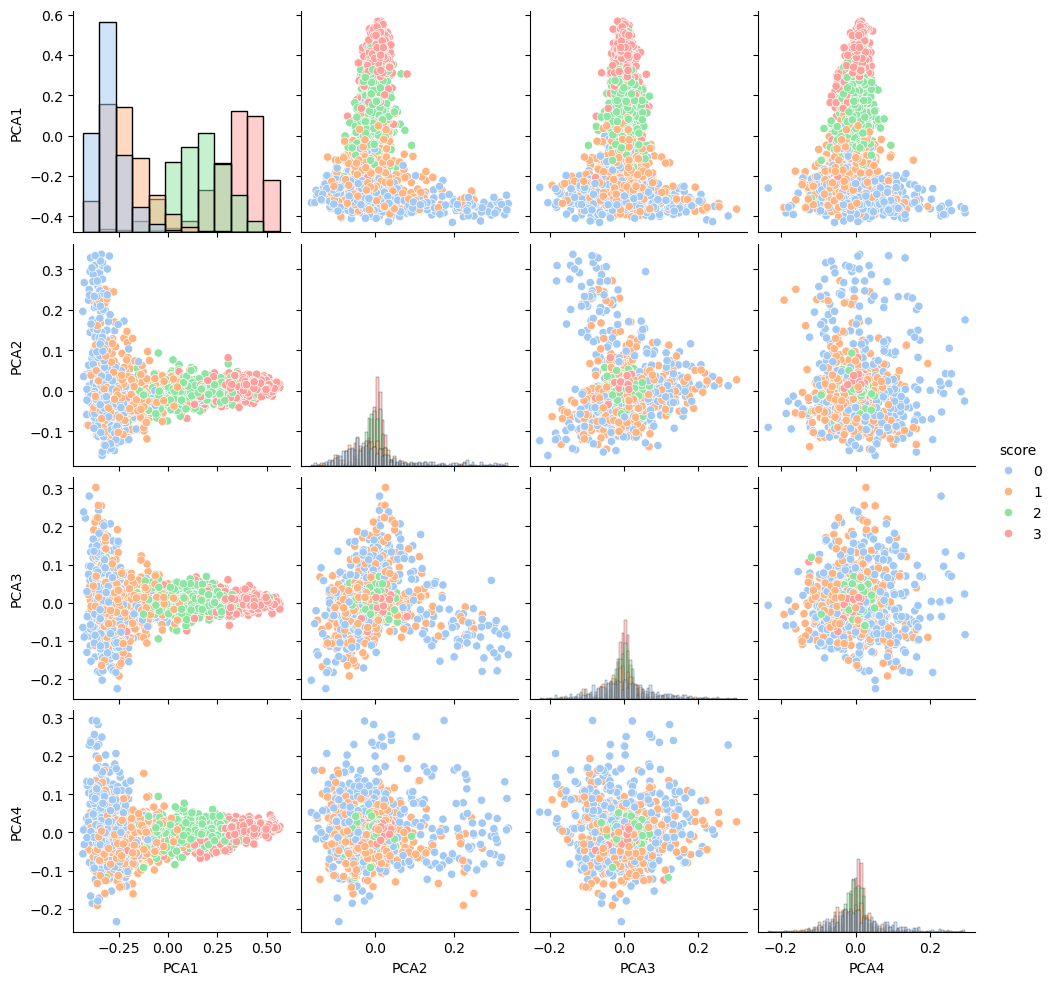

In [29]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=4)
components = pca.fit_transform(X)
pca_df= pd.DataFrame(components, columns=['PCA1','PCA2','PCA3','PCA4'])
pca_df['score']=y
pca_df
sns.pairplot(pca_df, hue="score", diag_kind="hist",palette="pastel")
plt.show()

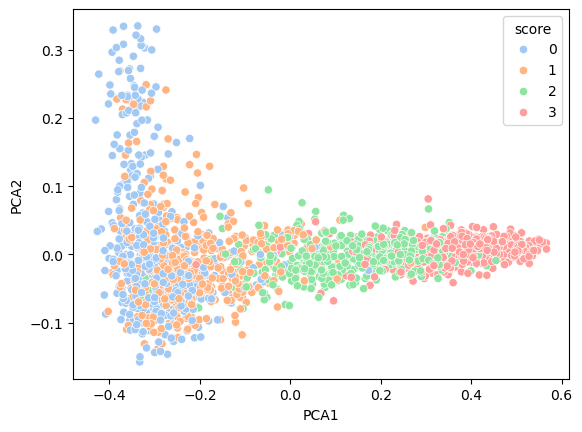

In [30]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
components = pca.fit_transform(X)
pca_df= pd.DataFrame(components, columns=['PCA1','PCA2'])
pca_df['score']=y
pca_df
sns.scatterplot(x='PCA1', y='PCA2', data=pca_df,hue="score",palette="pastel")
plt.show()

In [22]:
np.shape(X_train)

(1500, 768)

In [58]:
# KNN model
knn = KNeighborsClassifier()

#  PCA
pca = PCA()

#  pipeline with PCA and KNN
pipeline = Pipeline([
    ('pca', pca),
    ('knn', knn)
])

#  parameter grid for RandomizedSearchCV
param_knn = {
    'pca__n_components': [None, 2, 5, 10, 15], 
    'knn__n_neighbors': [1,3,5,7,9,11,13,15,17,19], 
    'knn__weights': ['uniform', 'distance'], 
    'knn__p': [1, 2], 
}

# Create RandomizedSearchCV object
t0 = time.time()
random_search_knn = RandomizedSearchCV(pipeline, param_distributions=param_knn, n_iter=100, cv=cv, scoring='accuracy', random_state=42)

# Fit the model
random_search_knn.fit(X_train, y_train)
t1 = time.time()

Time Taken by KNN  0.7344210902849834  minutes
Best Parameters: {'pca__n_components': 10, 'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 13}
Kendall's Tau: 0.7879794176640981
Classification Report for the Best Parameters:
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       125
           1       0.60      0.60      0.60       134
           2       0.70      0.79      0.74       114
           3       0.86      0.82      0.84       127

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.70       500
weighted avg       0.70      0.70      0.70       500

Number of training rounds = 600
Average training time per model configuration = 0.07 (s)


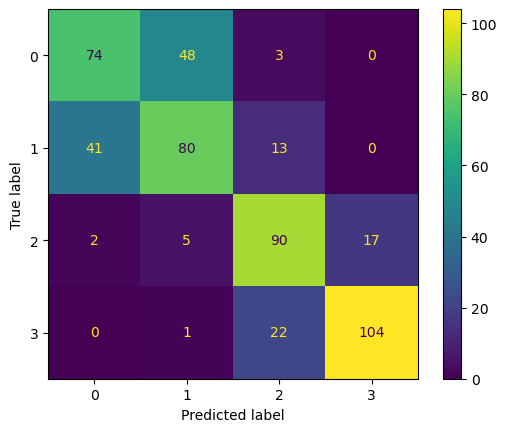

In [60]:
time_knn = t1 - t0
print("Time Taken by KNN ",time_knn/60 ," minutes")
best_estimator_knn = random_search_knn.best_estimator_
y_pred_knn = best_estimator_knn.predict(X_test)

# Generate the classification report
report_knn = classification_report(y_test, y_pred_knn)

print("Best Parameters:", random_search_knn.best_params_)

tau, _ = kendalltau(y_test, y_pred_knn)
print(f"Kendall's Tau: {tau}")

print("Classification Report for the Best Parameters:")
print(report_knn)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)
avg_training_time.append(calculate_avg_training_time(time_knn, param_knn, cv))

In [65]:
tau, _ = kendalltau(y_test, y_pred_knn)
kendalltau_store.append(tau)

In [61]:
pca=PCA()
pipe=  Pipeline([
    ('pca', pca),
    ('svm', SVC(probability=True, random_state=42))
])

param_svc = {
    'pca__n_components': [None, 2, 5, 10, 15],
    'svm__C': [0.1, 1, 10, 100, 1000],  
    'svm__kernel': ['linear', 'rbf'], 
    'svm__gamma': ['scale', 'auto'], 
    'svm__class_weight': [None, 'balanced'],
}

t0= time.time()
random_search_svc = RandomizedSearchCV(pipe, param_distributions=param_svc, 
                                   n_iter=100, cv=3, random_state=42)
random_search_svc.fit(X_train, y_train)
t1= time.time()


Number of training rounds = 600
Average training time per model configuration = 0.28 (s)
Time Taken by Support vector classifier  2.7769280274709067  minutes
Best Parameters: {'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__class_weight': None, 'svm__C': 10, 'pca__n_components': 10}
Kendall's Tau: 0.8044197957881365
Classification Report Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.57      0.58      0.57       125
           1       0.55      0.53      0.54       134
           2       0.69      0.71      0.70       114
           3       0.83      0.82      0.83       127

    accuracy                           0.66       500
   macro avg       0.66      0.66      0.66       500
weighted avg       0.66      0.66      0.66       500



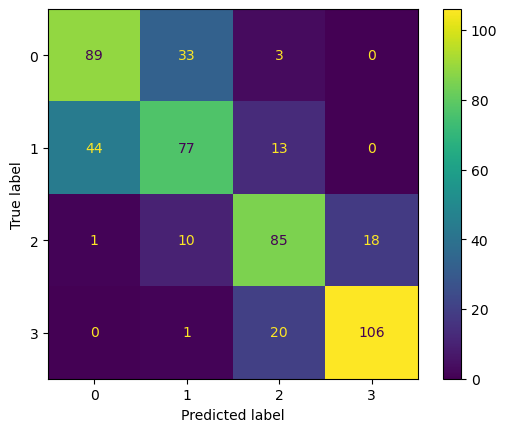

In [62]:
time_svc = t1 - t0
avg_training_time.append(calculate_avg_training_time(time_svc, param_svc, cv))
print("Time Taken by Support vector classifier ",time_svc/60 , " minutes")
best_estimator_svc = random_search_svc.best_estimator_
y_pred_svc = best_estimator_svc.predict(X_test)


report_svc = classification_report(y_test, y_pred)
print("Best Parameters:", random_search_svc.best_params_)

tau, _ = kendalltau(y_test, y_pred_svc)
print(f"Kendall's Tau: {tau}")

print("Classification Report Support Vector Classifier:")
print(report_svc)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc)

In [66]:
tau, _ = kendalltau(y_test, y_pred_svc)
kendalltau_store.append(tau)

In [63]:
params_rf = {
     'pca__n_components': [None, 2, 5, 10, 15],
    "model__max_depth": [3, 4, 5,10, None],
}
input = [("pca", PCA()), ("model", RandomForestClassifier())]

pipe = Pipeline(input)

t0= time.time()
random_serach_rf =RandomizedSearchCV(pipe, param_distributions=params_rf, n_iter=100, cv=3, scoring='accuracy', random_state=42)

random_serach_rf.fit(X_train, y_train)
t1= time.time()


Number of training rounds = 75
Average training time per model configuration = 1.55 (s)
Time Taken by Randome forest  1.9409353415171304  minutes
Best Parameters: {'pca__n_components': 10, 'model__max_depth': 10}
Kendall's Tau: 0.8007988388229
Classification Report for the Best Parameters:
              precision    recall  f1-score   support

           0       0.68      0.67      0.68       125
           1       0.66      0.61      0.63       134
           2       0.67      0.81      0.73       114
           3       0.86      0.78      0.82       127

    accuracy                           0.71       500
   macro avg       0.72      0.72      0.72       500
weighted avg       0.72      0.71      0.71       500



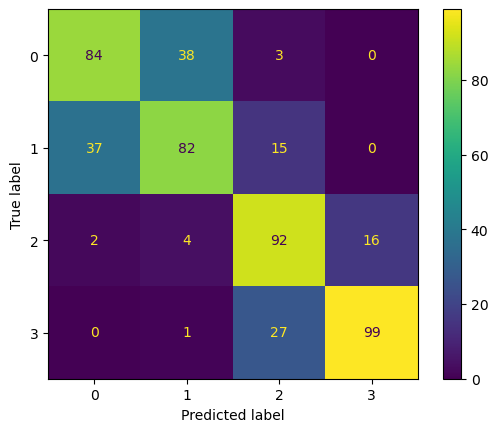

In [67]:
time_rf = t1 - t0
avg_training_time.append(calculate_avg_training_time(time_rf, params_rf, cv))
print("Time Taken by Randome forest ",time_rf/60 , " minutes")

best_estimator_rf = random_serach_rf.best_estimator_
y_pred_rf = best_estimator_rf.predict(X_test)

# Generate the classification report
report_rf = classification_report(y_test, y_pred_rf)
print("Best Parameters:", random_serach_rf.best_params_)

tau, _ = kendalltau(y_test, y_pred_rf)
print(f"Kendall's Tau: {tau}")

print("Classification Report for the Best Parameters:")
print(report_rf)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)

In [68]:
tau, _ = kendalltau(y_test, y_pred_rf)
kendalltau_store.append(tau)

In [71]:
print(kendalltau_store)
print(avg_training_time)


[0.7879794176640981, 0.8044197957881365, 0.8007988388229]
[0.07, 0.28, 1.55]


#### The below line graph with bar plot show the Average training time per model configuration, with the kendalltau score computed for best hyperparameters 

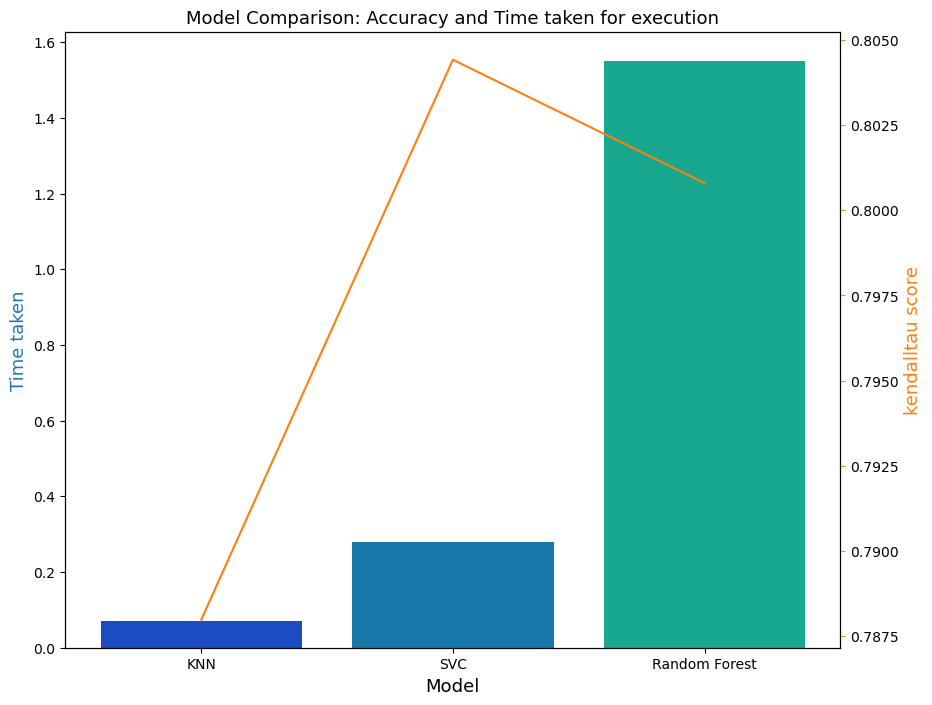

In [74]:
model_data = {
    "Model": [ "KNN",  "SVC", "Random Forest"],
    "kendalltau score": kendalltau_store,
    "Time taken": avg_training_time,
}

model_df = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.set_title("Model Comparison: Accuracy and Time taken for execution", fontsize=13)
color = "tab:blue"
ax1.set_xlabel("Model", fontsize=13)
ax1.set_ylabel("Time taken", fontsize=13, color=color)
ax2 = sns.barplot(x="Model", y="Time taken", data=model_df, palette="winter")
ax1.tick_params(axis="y")
ax2 = ax1.twinx()
color = "tab:orange"
ax2.set_ylabel("kendalltau score", fontsize=13, color=color)
ax2 = sns.lineplot(x="Model", y="kendalltau score", data=model_df, sort=False, color=color)
ax2.tick_params(axis="y", color=color)

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: initializes classifier
- `fit`: gets train data and labels as input to train the classifier
- `predict`: gets test data and outputs predictions made by the trained classifier


In this example code, the `Model` class implements a Gradient Boosting Classifier model. You can find the code in `M1-Challenge-Class-2024/Relevance/Starting_Kit/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

In [13]:
from model import Model

***
# Program
***
**`Ingestion program`** is responsible to run the submission of a participant on Codabench platform. **`Program`** is a simplified version of the **Ingestion Program** to show to participants how it runs a submission.
1. Train a model on train data
2. Predict using Test data

In [14]:
class Program():

    def __init__(self, data):

        # used to keep object of Model class to run the submission
        self.model = None
        # object of Data class used here to get the train and test sets
        self.data = data

        # results
        self.results = []

        print("==========================================")
        print("Program")
        print("==========================================")
    
    def initialize_submission(self):
        print("[*] Initializing Submmited Model")
        self.model = Model()
        ##############################################################################################
        # This part will go in model.py so that it will be called by self.model = Model()
        ##############################################################################################
        

    def fit_submission(self):
        print("[*] Calling fit method of submitted model")
        train_dataloader = DataLoader(self.data.get_train_data(), batch_size=8, shuffle=True)
        num_epochs=1
        self.model.fit(train_dataloader, num_epochs)
        ##############################################################################################
        # This part will go in model.py so that it will be called by self.model.fit(train_dataloader)
        ##############################################################################################


    def predict_submission(self):
        print("[*] Calling predict method of submitted model")
        test_dataloader = DataLoader(self.data.get_test_data(), batch_size=8, shuffle=False)
        self.y_test_hat, self.y_test_truth = self.model.predict(test_dataloader)
       

In [15]:
# Intiialize Program
program = Program(data=data)

Program


In [16]:
# Initialize submitted model
program.initialize_submission()

[*] Initializing Submmited Model
[*] - Initializing Classifier


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Call fit method of submitted model
program.fit_submission()

[*] Calling fit method of submitted model
[*] - Training Classifier on the train set


Epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Average training loss: 0.42189610242057823


In [18]:
# Call predict method of submitted model
program.predict_submission()

[*] Calling predict method of submitted model
[*] - Predicting test set using trained Classifier


***
# Score
***

The model’s performance is evaluated using several metrics, including precision, recall, F1-score, and Kendall’s Tau. These metrics provide a comprehensive view of the model’s performance across all classes. Precision measures the model’s exactness, recall measures its completeness, the F1-score balances precision and recall, and Kendall’s Tau measures the correlation between the predicted and actual rankings. 

1.	Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. It is also known as Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.

2.	Recall (Sensitivity): Recall is the ratio of correctly predicted positive observations to all the actual positives. It is also known as Sensitivity, Hit Rate, or True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.

3.	F1 Score: The F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is suitable for uneven class distribution problems.

4.	Support: Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing.

5.	Accuracy: Accuracy is the most intuitive performance measure. It is simply a ratio of correctly predicted observation to the total observations. One may think that if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost the same.

6.	Macro Avg: Macro-average method can be used when you want to know how the model performs overall across the sets of data. You should not come up with any specific decision with this average.

7.	Weighted Avg: In contrary to macro-average method, if you want to know how the model is performing with respect to the most frequent class, you should use a weighted-average method. This will aggregate the contributions of all classes to compute the average metric.

8.	Kendall’s Tau: Kendall’s Tau is a measure of correlation. It gives a value between -1 and 1. A value close to 1 means that there’s a strong positive correlation between the two variables, and a value close to -1 means that there’s a strong negative correlation. A value close to 0 means that there’s no correlation. In your case, the value is approximately 0.70, indicating a good agreement.

More info in: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html


In [19]:
class Score():

    def __init__(self, data, program):

        self.data = data
        self.program = program

        print("==========================================")
        print("Score")
        print("==========================================")

    def compute_scores(self):
        print("[*] Computing scores")

        y_test_ = np.array(self.program.y_test_truth)
        y_test = np.argmax(y_test_, axis=1)
        y_test_hat = self.program.y_test_hat

        # Classification report
        print(classification_report(y_test, y_test_hat))

        k_tau, _ = kendalltau(y_test, y_test_hat)
        print(f"Kendall's Tau: {round(k_tau, 3)}")

        kappa = cohen_kappa_score(y_test, y_test_hat)
        print(f"Cohen's Kappa: {round(kappa, 3)}")

In [20]:
# Initialize Score
score = Score(data=data, program=program)

Score


In [21]:
# Compute Score
score.compute_scores()

[*] Computing scores
              precision    recall  f1-score   support

           0       0.35      0.99      0.52       106
           1       0.00      0.00      0.00        91
           2       0.97      0.91      0.94       107
           3       0.00      0.00      0.00        96

    accuracy                           0.51       400
   macro avg       0.33      0.47      0.36       400
weighted avg       0.35      0.51      0.39       400

Kendall's Tau: 0.229
Cohen's Kappa: 0.326


***
# Submissions
***

### **Unit Testing**

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission.
<br>
Keep the sample code simple.<br>

<code>python3</code> is required for this step

### **Test Ingestion Program**

In [22]:
!python $program_dir/ingestion.py

############################################
### Ingestion Program
############################################

[*] Loading Data
[*] Transforming Data
[*] Prepare Data for Training
  0%|          | 0/500 [00:00<?, ?it/s]
[*] Initializing Submmited Model
[*] - Initializing Classifier
[*] Calling fit method of submitted model
[*] - Training Classifier on the train set
Epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]
Average training loss: 0.36017031581519404
[*] Calling predict method of submitted model
[*] - Predicting test set using trained Classifier
[*] Saving ingestion result

---------------------------------
Total duration: 1:45:45.392859
---------------------------------

----------------------------------------------
Ingestions Program executed successfully!
----------------------------------------------




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


### **Test Scoring Program**

In [23]:
!python $score_dir/score.py

############################################
### Scoring Program
############################################

[*] Reading predictions
[OK]
[*] Computing scores
              precision    recall  f1-score   support

           0       0.57      0.87      0.69       106
           1       0.50      0.13      0.21        91
           2       0.97      0.92      0.94       107
           3       0.82      0.97      0.89        96

    accuracy                           0.74       400
   macro avg       0.71      0.72      0.68       400
weighted avg       0.72      0.74      0.69       400

Kendall's Tau: 0.7911717138631795
[OK]
[*] Writing scores
[OK]

---------------------------------
[OK] Total duration: 0:00:00.015597
---------------------------------

----------------------------------------------
[OK] Scoring Program executed successfully!
----------------------------------------------




### **Prepare the submission**

TODOs:  
- The following submission will be submitted by the participants to your competition website. Describe this clearly and point to the competition once your website is ready

In [24]:
import datetime
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'Relevance-Baseline1-Sample_Data-Code_Submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `M1-Challenge-Class-2024/Relevance/Starting_Kit/")


Submit : Relevance-Baseline1-Sample_Data-Code_Submission_24-01-31-05-53.zip to the competition
You can find the zip file in `M1-Challenge-Class-2024/Relevance/Starting_Kit/
